In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/1dl034-project-vt25/sample_submission.csv
/kaggle/input/1dl034-project-vt25/taxi_zone_lookup.csv
/kaggle/input/1dl034-project-vt25/training_dataset.csv
/kaggle/input/1dl034-project-vt25/evaluation_dataset.csv


In [74]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import r2_score, accuracy_score #, root_mean_squared_log_error
#from pyspark.sql import SparkSession
import pandas as pd
from pandas.api.types import is_numeric_dtype as is_num
import numpy as np
import matplotlib.pyplot as plt
from joblib import parallel_backend
import seaborn as sns
from sklearn.preprocessing import Normalizer, MinMaxScaler

In [52]:
# spark = SparkSession.builder.appName("AIProject").config("spark.driver.memory", "4g").getOrCreate()
# data_frame = spark.read.csv('/kaggle/input/1dl034-project-vt25/training_dataset.csv', header=True, inferSchema=True)
# df = data_frame.limit(50000).toPandas()

In [53]:
df = pd.read_csv('/kaggle/input/1dl034-project-vt25/training_dataset.csv', nrows=500000)


In [54]:
df = df.dropna()
#df = df.fillna(method='bfill')


df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace(['N', 'Y'], [1, 2])

df = df.drop('ID', axis=1)
#df = df.drop('vendorid', axis=1)
df = df.drop('tpep_pickup_datetime', axis=1)
df = df.drop('tpep_dropoff_datetime', axis=1)

#df = df.interpolate()

df

<ipython-input-54-e74ebb534c46>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace(['N', 'Y'], [1, 2])


,vendorid,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,1.0,4.16,1.0,1,144,142,1,31.0,1.0,0.5,6.00,0.0,1.0,42.00,2.5,0.0,2116.0
1,2,1.0,1.03,1.0,1,144,79,1,10.0,1.0,0.5,2.00,0.0,1.0,17.00,2.5,0.0,549.0
2,2,2.0,0.62,1.0,1,230,186,2,-5.8,0.0,-0.5,0.00,0.0,-1.0,-9.80,-2.5,0.0,253.0
3,2,1.0,1.41,1.0,1,113,4,1,12.1,1.0,0.5,2.00,0.0,1.0,19.10,2.5,0.0,769.0
4,2,1.0,2.06,1.0,1,161,237,1,17.0,0.0,0.5,4.20,0.0,1.0,25.20,2.5,0.0,1110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2,3.0,0.67,1.0,1,211,231,1,8.6,0.0,0.5,2.52,0.0,1.0,15.12,2.5,0.0,502.0
499996,2,2.0,4.79,1.0,1,141,234,1,30.3,2.5,0.5,1.00,0.0,1.0,37.80,2.5,0.0,1779.0
499997,2,1.0,4.92,1.0,1,262,68,1,32.4,0.0,0.5,5.00,0.0,1.0,41.40,2.5,0.0,1840.0
499998,2,2.0,1.04,1.0,1,100,90,2,7.2,2.5,0.5,0.00,0.0,1.0,13.70,2.5,0.0,299.0


In [55]:
#numeric_columns = [
#    "passenger_count", "trip_distance", "pulocationid", "dolocationid",
#    "ratecodeid", "fare_amount", "extra", "mta_tax", "improvement_surcharge",
#    "tip_amount", "tolls_amount", "total_amount", "congestion_surcharge", "airport_fee", "duration"
#]

#for col in numeric_columns:
#    assert is_num(df[col])

In [56]:
x = df.iloc[:, :-1]
y = df["duration"]

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [57]:
print(x.shape)
print(y.shape)

(451742, 17)
(451742,)


0.03556194710771876


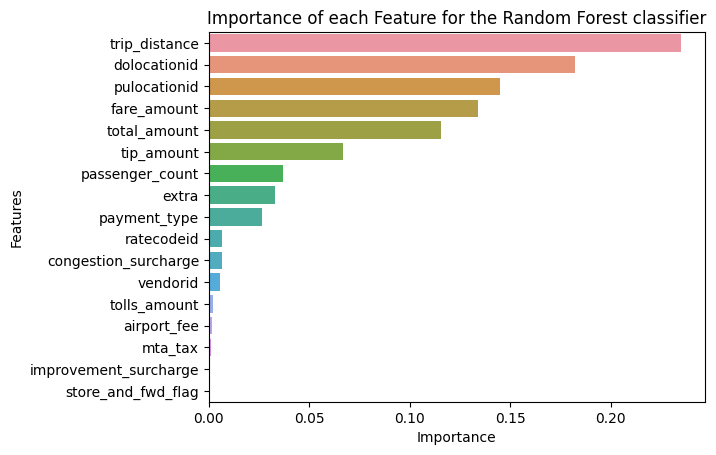

In [58]:
with parallel_backend('threading', n_jobs=4): 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    ranf_mod = RandomForestRegressor(random_state=42)
    ranf_mod.fit(x_train, y_train)
    
    y_pred_ranf = ranf_mod.predict(x_test)
    print(r2_score(y_test, y_pred_ranf))
    
    feature_scores = pd.Series(ranf_mod.feature_importances_, index = x_train.columns).sort_values(ascending = False)
    
sns.barplot(x=feature_scores, y=feature_scores.index, )
plt.title("Importance of each Feature for the Random Forest classifier")
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

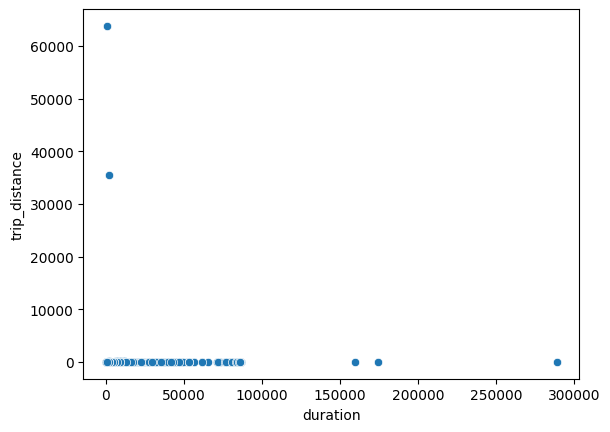

In [59]:
# plt.scatter(df['duration'], df['trip_distance'])
scatter = sns.scatterplot(x='duration', y='trip_distance', data=df)
#scatter.set_xlim(left= 0, right=7000)
# sns.scatterplot(y='duration', x='trip_distance', data=df)

Removing outliers

In [60]:
max_speed = 50
min_duration = 0
cutoff_duration = 3000

df = df[(df['duration']) > min_duration]
df2 = df[(df['trip_distance'] / (df['duration'] / (60 * 60))) < max_speed] # 50 because 50 mph we set as max
df2 = df2.drop(df2[(df2['duration'] > cutoff_duration) & (df2['trip_distance'] / ((df2['duration'] - cutoff_duration) / (60*60)) < max_speed)].index)


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


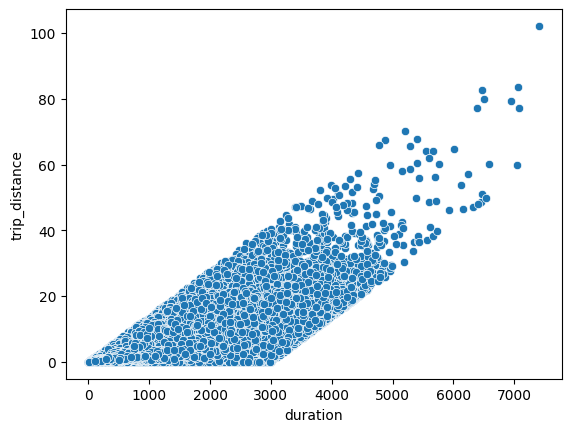

In [61]:
scatter = sns.scatterplot(x='duration', y='trip_distance', data=df2)
#scatter.set_xlim(left= 0, right=7000)

In [62]:
scaler = Normalizer()
scaled_data = scaler.fit_transform(df2)
df2 = pd.DataFrame(scaled_data, columns=df2.columns)


In [63]:
x = df2.iloc[:, :-1]
y = df2["duration"]

In [64]:
def rmsle(targets, predictions):
    """Calculate the root mean squared logarithmic error between predictions and targets"""
    return np.sqrt(np.mean((np.log(predictions + 1) - np.log(targets + 1)) ** 2))

In [65]:

#df = df.drop('store_and_fwd_flag', axis=1)
#df = df.drop('airport_fee', axis=1)
#df = df.drop('mta_tax', axis=1)
#df = df.drop('tolls_amount', axis=1)
#df = df.drop('improvement_surcharge', axis=1)
#df = df.drop('congestion_surcharge', axis=1)
#df = df.drop('ratecodeid', axis=1)
#df = df.drop('passenger_count', axis=1)

#df2 = df2.drop('store_and_fwd_flag', axis=1)
#df2 = df2.drop('improvement_surcharge', axis=1)
#df2 = df2.drop('airport_fee', axis=1)
#df2 = df2.drop('payment_type', axis=1)
#df2 = df2.drop('congestion_surcharge', axis=1)

#df2 = df2.drop('tolls_amount', axis=1)
#df2 = df2.drop('mta_tax', axis=1)
#df = df.drop('tolls_amount', axis=1)
#df = df.drop('ratecodeid', axis=1)
#df = df.drop('passenger_count', axis=1)

#df2 = df2.drop('total_amount', axis=1)
#df2 = df2.drop('dolocationid', axis=1)
#df2 = df2.drop('pulocationid', axis=1)
#df2 = df2.drop('extra', axis=1)
#df2 = df2.drop('tip_amount', axis=1)


In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

with parallel_backend('threading', n_jobs=4):     
    ranf_mod = RandomForestRegressor(random_state=42)
    ranf_mod.fit(x_train, y_train)
    
    y_pred_ranf = ranf_mod.predict(x_test)


print('r2', r2_score(y_test, y_pred_ranf))
print('log error', rmsle(y_test, y_pred_ranf))

r2 0.997437281612577
log error 0.0059137057811114125


In [67]:
#from xgboost import XGBRegressor

#my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
#my_model.fit(x_train, y_train, verbose=False)

#predictions = my_model.predict(x_test)

#print('r2', r2_score(y_test, predictions))
#print('log error', rmsle(y_test, predictions))

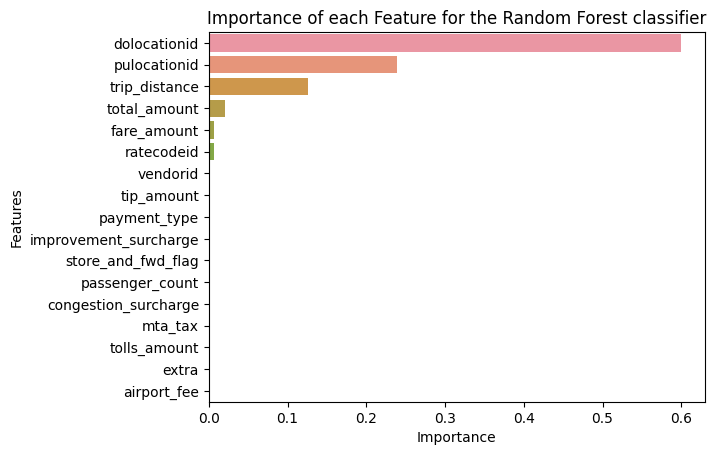

In [68]:
feature_scores = pd.Series(ranf_mod.feature_importances_, index = x_train.columns).sort_values(ascending = False)

sns.barplot(x=feature_scores, y=feature_scores.index, )
plt.title("Importance of each Feature for the Random Forest classifier")
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Evaluation dataset

In [88]:
df_eval = pd.read_csv('/kaggle/input/1dl034-project-vt25/evaluation_dataset.csv')

#df_eval = df_eval.dropna()
#df_eval = df_eval.fillna(method='bfill')

df_eval['store_and_fwd_flag'] = df_eval['store_and_fwd_flag'].replace(['N', 'Y'], [1, 2])

IDs = df_eval['ID']

df_eval = df_eval.drop('ID', axis=1)
#df_eval = df_eval.drop('vendorid', axis=1)
df_eval = df_eval.drop('tpep_pickup_datetime', axis=1)

df_eval = df_eval.interpolate()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_eval)
df_eval = pd.DataFrame(scaled_data, columns=df_eval.columns)


with parallel_backend('threading', n_jobs=4):     
    y_pred_ranf = ranf_mod.predict(df_eval)

<ipython-input-88-77f27bfc7207>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eval['store_and_fwd_flag'] = df_eval['store_and_fwd_flag'].replace(['N', 'Y'], [1, 2])


In [90]:
data = {'ID': IDs, 'duration': y_pred_ranf}
df_sub = pd.DataFrame(data)

pred_val = scaler.inverse_transform(df_sub['duration'])

data = {'ID': IDs, 'duration': pred_val}
df_sub = pd.DataFrame(data)

print(df_sub)
df_sub.to_csv('sample_submission.csv', index=False, header=True)

ValueError: Expected 2D array, got 1D array instead:
array=[0.65413131 0.71109331 0.13981746 ... 0.17969049 0.81935409 0.68477387].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.